In [5]:
import datetime, time
import itertools
import numpy as np
import pandas as pd
import networkx as nx
from functools import reduce
#from pyspark.sql import Window
#from pyspark.sql import SparkSession
#from pyspark.sql.types import (StructField, StringType,FloatType, 
#                               DoubleType, IntegerType, StructType,
#                              DateType)
#from pyspark.sql import functions as F
#from pyspark.sql import DataFrame as spDataFrame


#from pyspark.ml import Pipeline, PipelineModel
#from pyspark.ml.feature import (Binarizer, OneHotEncoder, StringIndexer, HashingTF, 
#                                Tokenizer, StandardScaler, VectorAssembler,
#                               OneHotEncoder, StringIndexer, VectorIndexer)
#from pyspark.ml.classification import LogisticRegression, LinearSVC, LinearSVCModel
#from pyspark.ml.evaluation import HasFeaturesCol
#from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import os
import matplotlib.pyplot as plt
import seaborn as sns

#from sklearn.pipeline import Pipeline, make_pipeline, make_union
#from sklearn.multiclass import OneVsOneClassifier
#from sklearn.feature_selection import chi2, RFECV, SelectKBest
#from sklearn.decomposition import PCA, NMF
#from sklearn.svm import SVC
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import confusion_matrix
#from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
#from sklearn.linear_model import SGDClassifier, LogisticRegression
#from sklearn.preprocessing import StandardScaler
#from sklearn.externals.joblib import parallel_backend

#from imblearn.over_sampling import SMOTE
#from imblearn.pipeline import Pipeline

#import xgboost as xgb
import plotly
#import luminol
import plotly.plotly as py
import plotly.graph_objs as go

In [3]:
plotly.tools.set_credentials_file(username='smillett', api_key='MXYpm8AMvEte7SSw6dKu')

# Import CSV Data

In [6]:
# Import dataset
start_time = time.time()
master_df = pd.read_csv('../Dataset/Output/complete_5m_df.csv')
print("--- %s seconds ---" % (time.time() - start_time))

--- 185.89728355407715 seconds ---


# Data cleaning

In [7]:
#replace all missing values with 0
master_df = master_df.replace(-999, 0)
master_df['time']=pd.to_datetime(master_df['time'])

In [8]:
print(master_df.shape)
master_df.head()

(129295890, 15)


,src_comp,time,fail_count,LoggedOn,dns_count,newresolved_count,dur,pkt_cnt,byte_cnt,avg_pkt_size,redteam_event,proc_total,proc_exec_total,newexecute_count,Proc_run
0,C1,2017-01-01 00:00:00,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0
1,C1,2017-01-01 00:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0
2,C1,2017-01-01 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0
3,C1,2017-01-01 00:15:00,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0
4,C1,2017-01-01 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0


In [9]:
resampled_df = master_df.groupby('time').agg({'redteam_event':'sum',
                                               'dns_count':'mean',
                                               'newresolved_count':'mean',
                                               'fail_count':'mean',
                                               'LoggedOn':'mean',
                                               'dur':'mean',
                                               'pkt_cnt':'mean',
                                               'byte_cnt':'mean',
                                               'avg_pkt_size':'mean',
                                               'proc_total':'mean',
                                               'proc_exec_total':'mean',
                                               'newexecute_count':'mean',
                                               'Proc_run':'mean'} )
resampled_df.index = pd.to_datetime(resampled_df.index)
resampled_df['redteam_event'] = resampled_df.redteam_event.map(lambda x: 1 if x > 0 else x)
#redteam_events = resampled_df[resampled_df['redteam_event']>0].index

# Look at Size, Shape and Examples of Data

In [11]:
reduced_df = master_df[master_df['time']<=('2017-01-03')]

In [12]:
print (reduced_df.shape)
reduced_df.head()

(5394014, 15)


,src_comp,time,fail_count,LoggedOn,dns_count,newresolved_count,dur,pkt_cnt,byte_cnt,avg_pkt_size,redteam_event,proc_total,proc_exec_total,newexecute_count,Proc_run
0,C1,2017-01-01 00:00:00,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0
1,C1,2017-01-01 00:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0
2,C1,2017-01-01 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0
3,C1,2017-01-01 00:15:00,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0
4,C1,2017-01-01 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0


# Build charts looking for outliers
### Noise is removed by only looking at samples above a certain count
### We assume a feature with zero events in a time frame is not an IOC

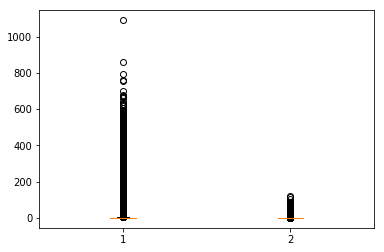

In [13]:
# First look at boxplots of sample features showing how noise prevents seeing outliers
plt.figure()
plt.boxplot([reduced_df['LoggedOn'],reduced_df['dns_count']]);

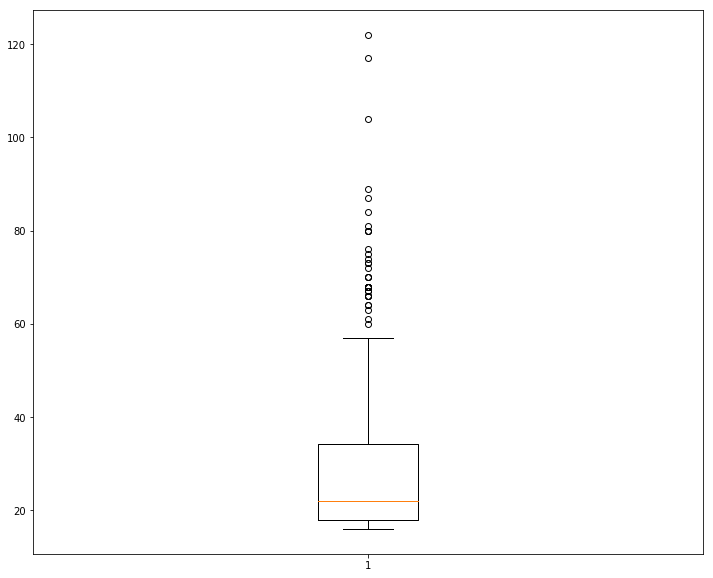

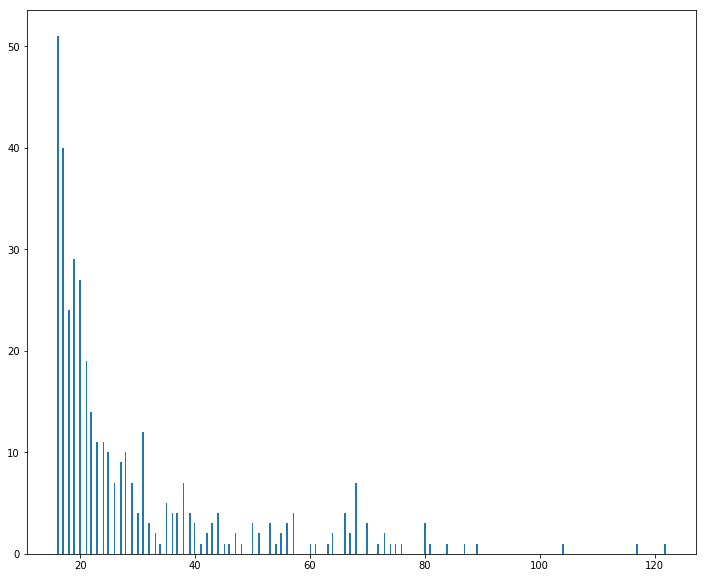

src_comp             388
time                 388
fail_count           388
LoggedOn             388
dns_count            388
newresolved_count    388
dur                  388
pkt_cnt              388
byte_cnt             388
avg_pkt_size         388
redteam_event        388
proc_total           388
proc_exec_total      388
newexecute_count     388
Proc_run             388
dtype: int64

In [20]:
# Examine dns_count feature
dns_remove_noise = reduced_df[(reduced_df[['dns_count']] >15).all(axis=1)]
#print("We removed {:02.3f}".format(1-(dns_remove_noise.count()/reduced_df.count())))
plt.figure(figsize=(12,10))
plt.boxplot(dns_remove_noise['dns_count'])
plt.figure(figsize=(12,10))
plt.hist(dns_remove_noise['dns_count'],bins=int(388))
plt.show()
dns_remove_noise.count()

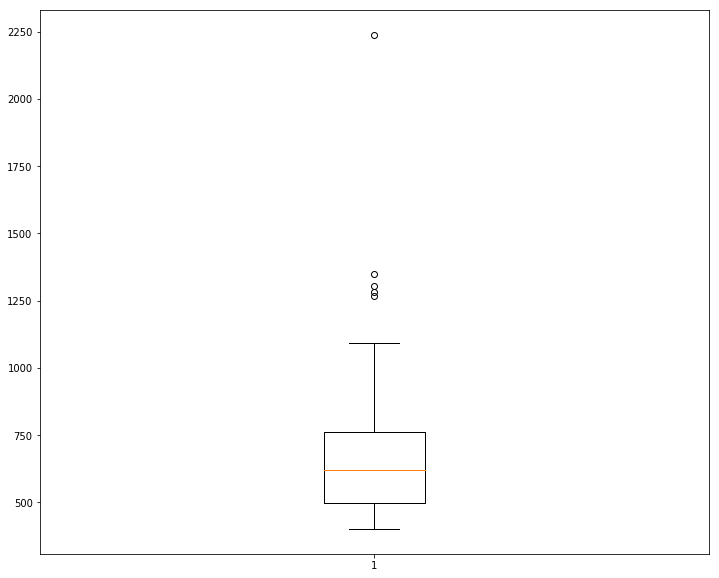

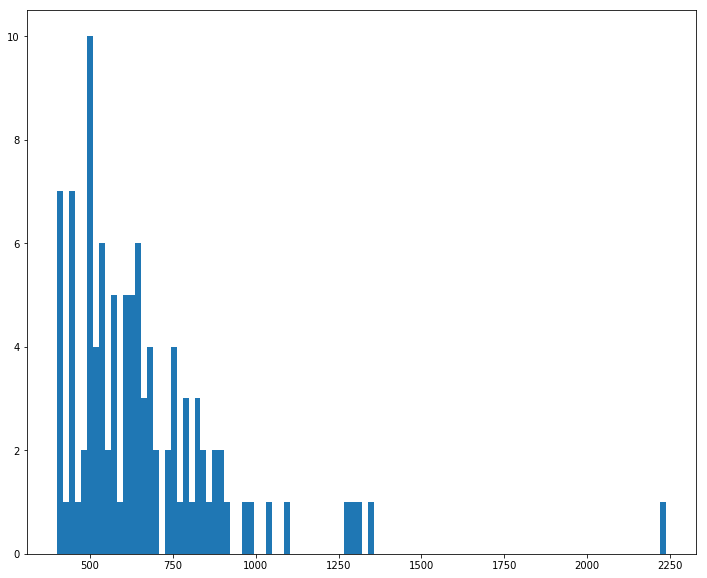

src_comp             102
time                 102
fail_count           102
LoggedOn             102
dns_count            102
newresolved_count    102
dur                  102
pkt_cnt              102
byte_cnt             102
avg_pkt_size         102
redteam_event        102
proc_total           102
proc_exec_total      102
newexecute_count     102
Proc_run             102
dtype: int64

In [49]:
# Examine Processes Run feature
proc_remove_noise = reduced_df[(reduced_df[['Proc_run']] >400).all(axis=1)]
plt.figure(figsize=(12,10))
plt.boxplot(proc_remove_noise['Proc_run'])
plt.figure(figsize=(12,10))
plt.hist(proc_remove_noise['Proc_run'],bins=int(102))
plt.show()
proc_remove_noise.count()

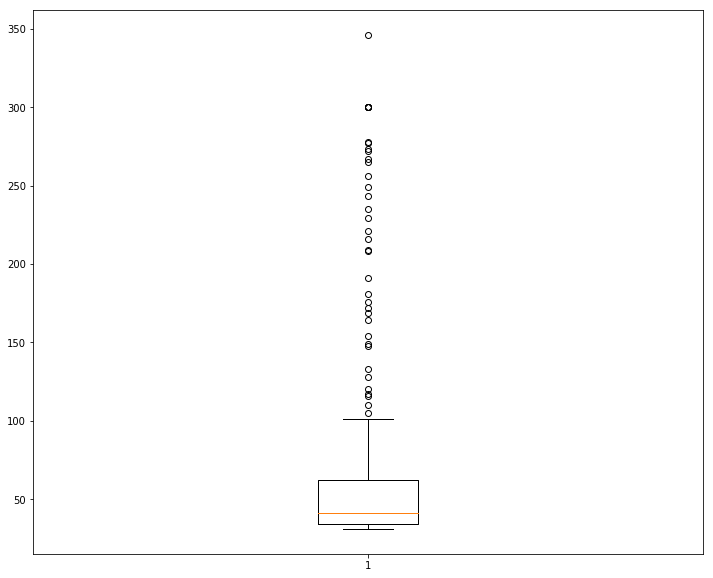

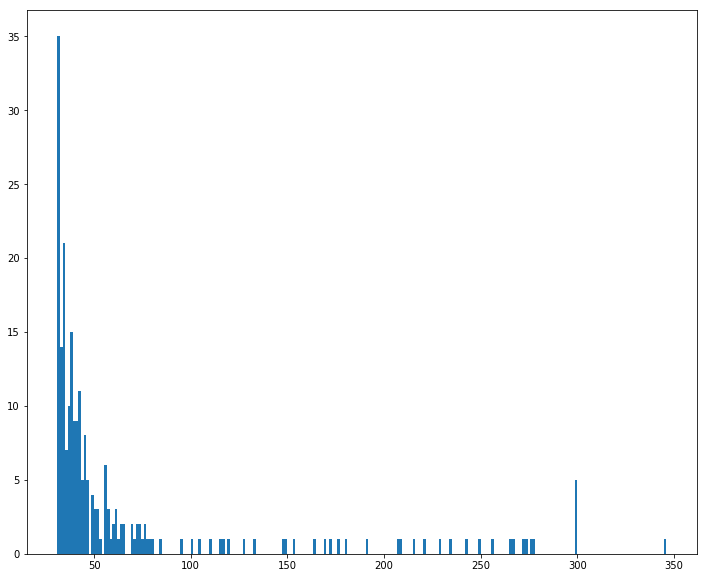

src_comp             233
time                 233
fail_count           233
LoggedOn             233
dns_count            233
newresolved_count    233
dur                  233
pkt_cnt              233
byte_cnt             233
avg_pkt_size         233
redteam_event        233
proc_total           233
proc_exec_total      233
newexecute_count     233
Proc_run             233
dtype: int64

In [27]:
# Examine fail_count feature
failCnt_remove_noise = reduced_df[(reduced_df[['fail_count']] >30).all(axis=1)]
plt.figure(figsize=(12,10))
plt.boxplot(failCnt_remove_noise['fail_count'])
plt.figure(figsize=(12,10))
plt.hist(failCnt_remove_noise['fail_count'],bins=int(233))
plt.show()
failCnt_remove_noise.count()

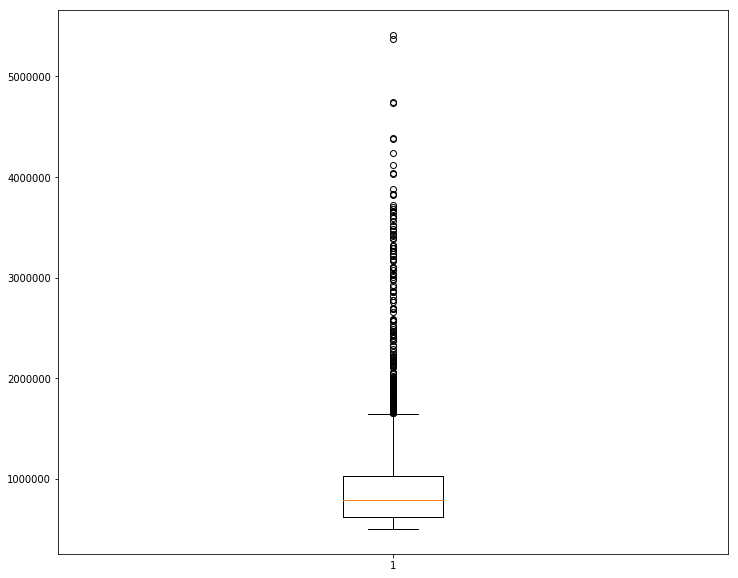

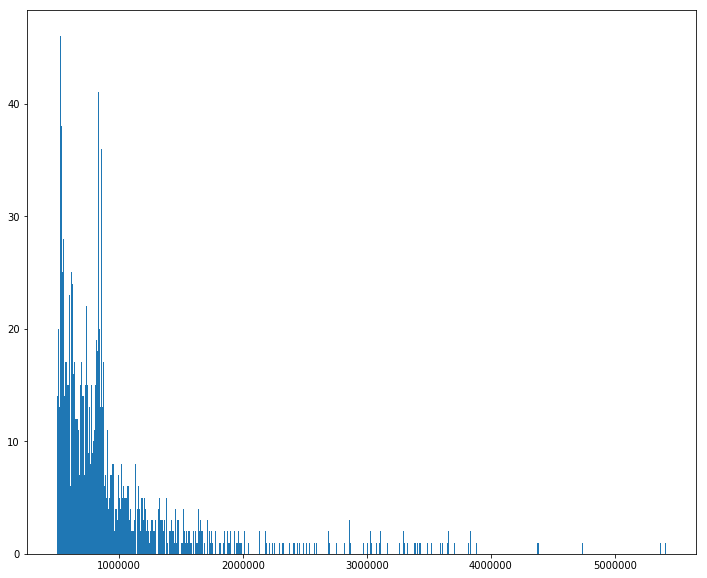

src_comp             1939
time                 1939
fail_count           1939
LoggedOn             1939
dns_count            1939
newresolved_count    1939
dur                  1939
pkt_cnt              1939
byte_cnt             1939
avg_pkt_size         1939
redteam_event        1939
proc_total           1939
proc_exec_total      1939
newexecute_count     1939
Proc_run             1939
dtype: int64

In [36]:
# Examine pkt_cnt feature
pkt_remove_noise = reduced_df[(reduced_df[['pkt_cnt']] >500000).all(axis=1)]
plt.figure(figsize=(12,10))
plt.boxplot(pkt_remove_noise['pkt_cnt'])
plt.figure(figsize=(12,10))
plt.hist(pkt_remove_noise['pkt_cnt'],bins=int(950))
plt.show()
pkt_remove_noise.count()

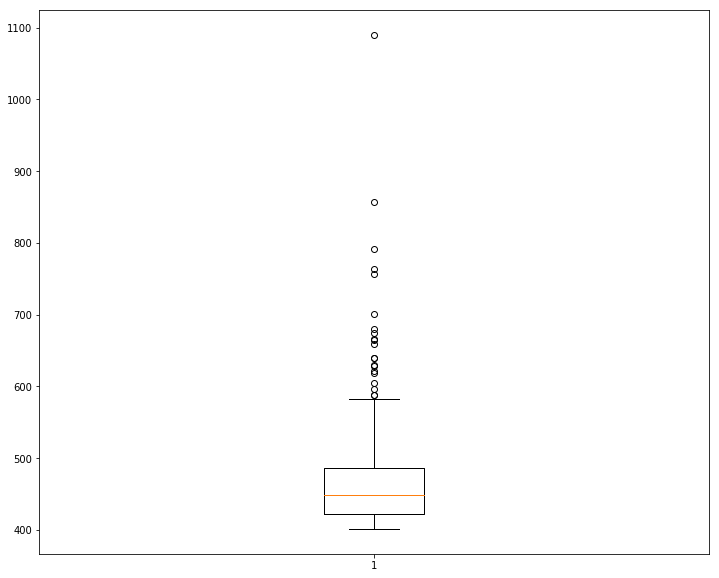

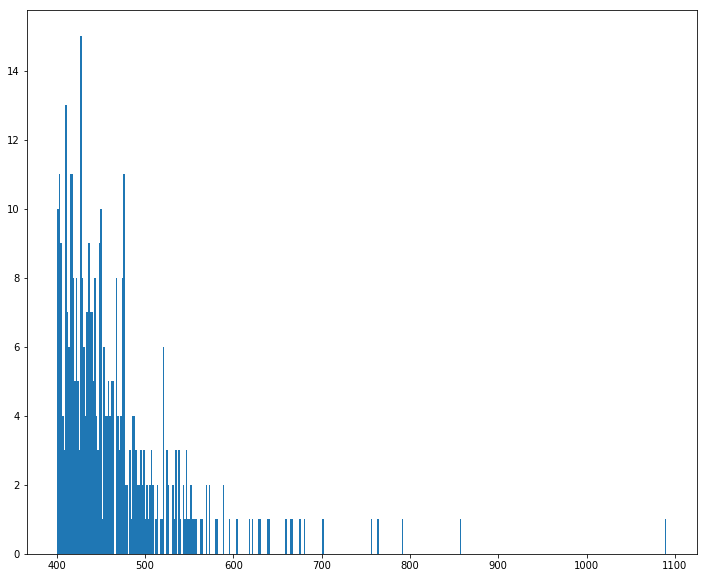

src_comp             398
time                 398
fail_count           398
LoggedOn             398
dns_count            398
newresolved_count    398
dur                  398
pkt_cnt              398
byte_cnt             398
avg_pkt_size         398
redteam_event        398
proc_total           398
proc_exec_total      398
newexecute_count     398
Proc_run             398
dtype: int64

In [38]:
# Examine LoggedOn feature
LoggedOn_remove_noise = reduced_df[(reduced_df[['LoggedOn']] >400).all(axis=1)]
plt.figure(figsize=(12,10))
plt.boxplot(LoggedOn_remove_noise['LoggedOn'])
plt.figure(figsize=(12,10))
plt.hist(LoggedOn_remove_noise['LoggedOn'],bins=int(398))
plt.show()
LoggedOn_remove_noise.count()

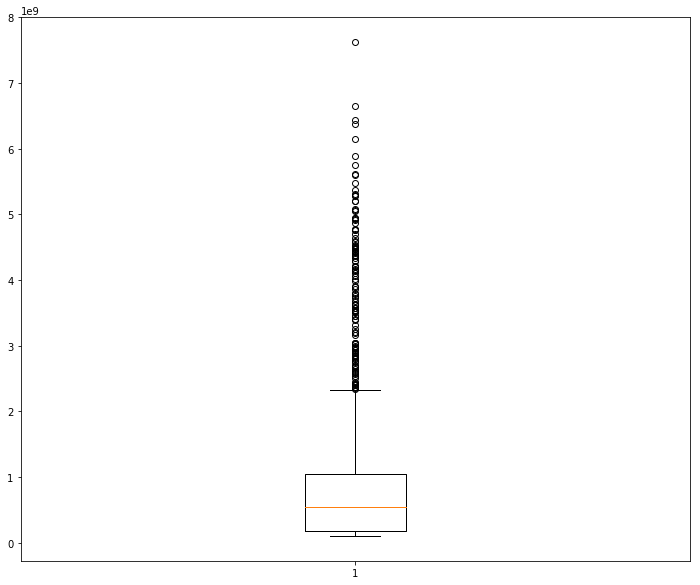

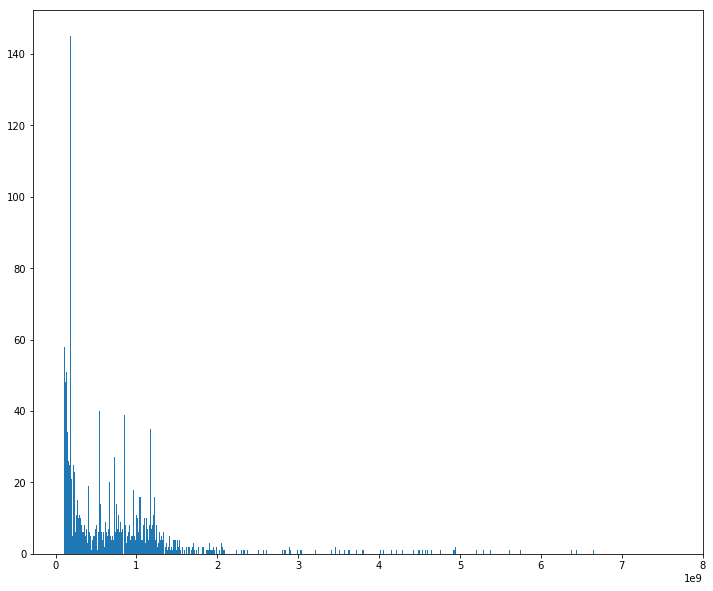

src_comp             3441
time                 3441
fail_count           3441
LoggedOn             3441
dns_count            3441
newresolved_count    3441
dur                  3441
pkt_cnt              3441
byte_cnt             3441
avg_pkt_size         3441
redteam_event        3441
proc_total           3441
proc_exec_total      3441
newexecute_count     3441
Proc_run             3441
dtype: int64

In [44]:
# Examine byte_cnt feature
byte_remove_noise = reduced_df[(reduced_df[['byte_cnt']] >100000000).all(axis=1)]
plt.figure(figsize=(12,10))
plt.boxplot(byte_remove_noise['byte_cnt'])
plt.figure(figsize=(12,10))
plt.hist(byte_remove_noise['byte_cnt'],bins=int(1500))
plt.show()
byte_remove_noise.count()

In [ ]:
# Make chart time vs high number of IOC